In [2]:
pip install tables

     |████████████████████████████████| 4.7 MB 8.9 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached blosc2-2.5.1-cp39-cp39-macosx_11_0_arm64.whl (3.5 MB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)
  Using cached ndindex-1.8-py3-none-any.whl (91 kB)
  Using cached msgpack-1.0.8-cp39-cp39-macosx_11_0_arm64.whl (85 kB)
  Created wheel for tables: filename=tables-3.9.2-cp39-cp39-macosx_11_0_arm64.whl size=3442561 sha256=ad0b512d927609e478cb0bd6899bd8f94841e2e5bea4f7f6845e11f46dc6ad72
  Stored in directory: /Users/apple/Library/Caches/pip/wheels/29/2d/d0/b34b665869e7ee11ebf384d23fd3b854e4d8217cf8877b8ab0
Successfully built tables
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tables
import numpy as np

In [4]:
def load_spike(file_path='final_dataset.h5'):
    h5_path = file_path
    # model_save_dir = path_vars['model_save_dir'] # Directory in which trained model will be saved


    # Load equal numbers of waveforms for pos,neg, split into train,test
    # Since positive samples are >> negative, we will subsample from them
    neg_path = '/sorted/neg'
    pos_path = '/sorted/pos'

    neg_waveforms = []
    pos_waveforms = []

    h5 = tables.open_file(h5_path, 'r')
    for x in h5.iter_nodes(neg_path):
        neg_waveforms.append(x[:])

    neg_waveforms = np.concatenate(neg_waveforms, axis=0)

    # pos_waveforms needs to be of length 75, or 750 that can be downsampled
    pos_node_list = list(h5.iter_nodes(pos_path))
    # Waveforms with same length as neg_waveforms
    pos_matched_units = [x for x in pos_node_list
                        if x.shape[1] == neg_waveforms.shape[1]]
    waveforms_per_unit = neg_waveforms.shape[0]//len(pos_matched_units)

    # with tables.open_file(h5_path,'r') as h5:
    for x in pos_matched_units:
        ind = np.min([x.shape[0], waveforms_per_unit])
        pos_waveforms.append(x[:ind, :])
    pos_waveforms = np.concatenate(pos_waveforms, axis=0)
    h5.close()

    neg_label = [0]*neg_waveforms.shape[0]
    pos_label = [1]*pos_waveforms.shape[0]
    fin_labels = np.concatenate([neg_label, pos_label])

    return [neg_waveforms, pos_waveforms, neg_label, pos_label, fin_labels]



In [5]:
[neg_waveforms, pos_waveforms, neg_label, pos_label, fin_labels] = load_spike()

In [41]:
def signal_to_noise_ratio(waveform):
    # assume signal region ranges from 20th time step to 40th time step.
    # waveform is numpy array
    signal_region = waveform[20:40]
    noise_region = np.concatenate((waveform[0:20], waveform[40:len(waveform)]))
    
    
    signal_amplitude = np.max(signal_region) - np.min(signal_region)
    noise_level = np.std(noise_region)
    
    return signal_amplitude/noise_level

def get_snr(dataset):
    size = len(dataset)
    neg_SNR = np.zeros(size)
    for i in range(0, size):
        neg_SNR[i] = signal_to_noise_ratio(dataset[i])
        
    return neg_SNR

In [45]:
a = get_snr(pos_waveforms)
b = get_snr(neg_waveforms)

In [105]:
np.percentile(a,20)

5.694732409350536

In [101]:
np.percentile(b,99)

7.315676383411562

In [102]:
np.min(a)

0.3162964125931022

In [49]:
np.mean(b)

3.2507793799460933

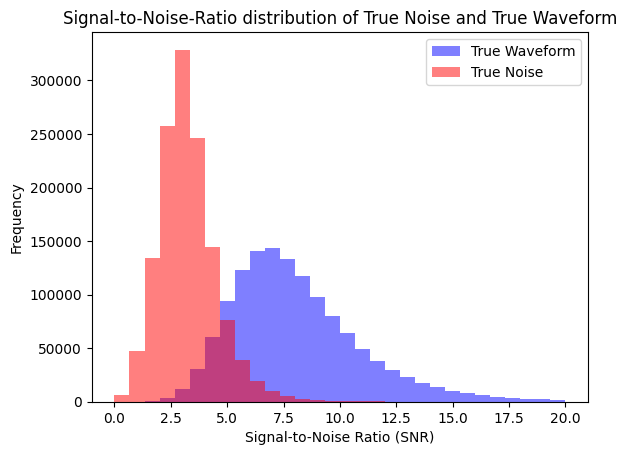

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Plot histogram for positive SNR dataset
plt.hist(a, bins=30, range=(0, 20), color='blue', alpha=0.5, label='True Waveform')

# Plot histogram for negative SNR dataset
plt.hist(b, bins=30, range=(0, 20), color='red', alpha=0.5, label='True Noise')

# Add labels and legend
plt.xlabel('Signal-to-Noise Ratio (SNR)')
plt.ylabel('Frequency')
plt.title('Signal-to-Noise-Ratio distribution of True Noise and True Waveform')
plt.legend()

# Show plot
plt.show()


In [84]:
pos = 0
index_pos = []

for i in range(0, len(pos_waveforms)):
    waveform = pos_waveforms[i]
    
    max_index = np.argmax(waveform)
    if max_index<35 and max_index>25:
        pos += 1
        index_pos.append(i)
        
print(pos)
print(index_pos[1:100])


59257
[5881, 5882, 5883, 5884, 5885, 5886, 5887, 5888, 5889, 5890, 5891, 5892, 5893, 5894, 5895, 5896, 5897, 5898, 5899, 5900, 5901, 5902, 5903, 5904, 5905, 5906, 5907, 5908, 5909, 5910, 5911, 5912, 5913, 5914, 5915, 5916, 5917, 5918, 5919, 5920, 5921, 5922, 5923, 5924, 5925, 5926, 5927, 5928, 5929, 5930, 5931, 5932, 5933, 5934, 5935, 5936, 5937, 5938, 5939, 5940, 5941, 5942, 5943, 5944, 5945, 5946, 5947, 5948, 5949, 5950, 5951, 5952, 5953, 5954, 5955, 5956, 5957, 5958, 5959, 5960, 5961, 5962, 5963, 5964, 5965, 5966, 5967, 5968, 5969, 5970, 5971, 5972, 5973, 5974, 5975, 5976, 5977, 5978, 5979]


In [114]:
neg = 0
index_neg = []

for i in range(0, len(neg_waveforms)):
    waveform = neg_waveforms[i]
    
    max_index = np.argmax(waveform)
    if max_index<33 and max_index>27:
        neg += 1
        index_neg.append(i)
        
print(neg)
print(index_neg[1:100])

339484
[3, 5, 7, 9, 11, 13, 14, 18, 19, 21, 25, 31, 33, 35, 37, 39, 42, 44, 46, 49, 54, 57, 60, 63, 65, 68, 72, 74, 75, 77, 79, 82, 87, 89, 93, 101, 103, 105, 107, 109, 112, 116, 118, 120, 122, 129, 134, 136, 138, 141, 143, 145, 148, 152, 157, 158, 160, 162, 164, 166, 168, 169, 174, 177, 180, 182, 184, 186, 195, 197, 201, 205, 210, 214, 216, 218, 222, 225, 228, 230, 234, 236, 238, 240, 241, 243, 246, 248, 250, 252, 256, 259, 262, 264, 266, 268, 270, 272, 275]


In [117]:
neg = 0
index_neg = []

for i in range(0, len(pos_waveforms)):
    waveform = pos_waveforms[i]
    

    if waveform[30] == np.max(waveform[20:40]):
        neg += 1
        index_neg.append(i)
        
print(neg)
print(index_neg[1:100])

59587
[5881, 5882, 5883, 5884, 5885, 5886, 5887, 5888, 5889, 5890, 5891, 5892, 5893, 5894, 5895, 5896, 5897, 5898, 5899, 5900, 5901, 5902, 5903, 5904, 5905, 5906, 5907, 5908, 5909, 5910, 5911, 5912, 5913, 5914, 5915, 5916, 5917, 5918, 5919, 5920, 5921, 5922, 5923, 5924, 5925, 5926, 5927, 5928, 5929, 5930, 5931, 5932, 5933, 5934, 5935, 5936, 5937, 5938, 5939, 5940, 5941, 5942, 5943, 5944, 5945, 5946, 5947, 5948, 5949, 5950, 5951, 5952, 5953, 5954, 5955, 5956, 5957, 5958, 5959, 5960, 5961, 5962, 5963, 5964, 5965, 5966, 5967, 5968, 5969, 5970, 5971, 5972, 5973, 5974, 5975, 5976, 5977, 5978, 5979]


# plot positive deflection

In [81]:
def plot_wave(df, i, j, pos):
    [waveform1, waveform2, label1, label2] = generate(df, i, j, pos)
    plt.figure(figsize=(10, 4))
    t = np.linspace(0, 75, 75)
    # Plot waveform 1
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.plot(t, np.array(waveform1))
    plt.title(label1)
    plt.xlabel('Time (AU)')
    plt.ylabel('Amplitude (mV)')
    plt.grid(True)
    plt.legend()

    # Plot sample noise
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.plot(t, np.array(waveform2))
    plt.title(label2)
    plt.xlabel('Time (AU)')
    plt.ylabel('Amplitude (mV)')
    plt.grid(True)
    plt.legend()

    # Display the plots
    plt.tight_layout()  # Adjust the layout to make room for the labels/titles
    plt.show()
    
def generate(df, i, j, pos):
    if pos:
        label = 'positive'
    else:
        label = 'negative'
        
    waveform1 = df[i]
    waveform2 = df[j]
    label1 = label + ' waveform index #'+ str(i)
    label2 = label + ' waveform index #'+ str(j)
    return [waveform1, waveform2, label1, label2]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


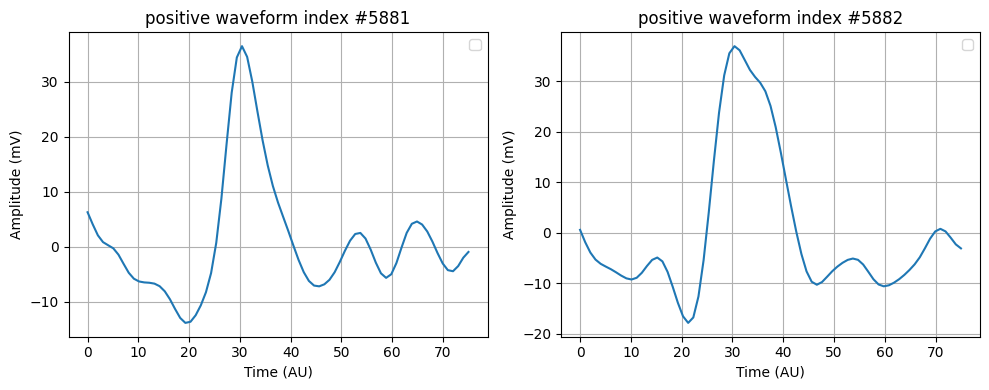

In [82]:
plot_wave(pos_waveforms, 5881, 5882, 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


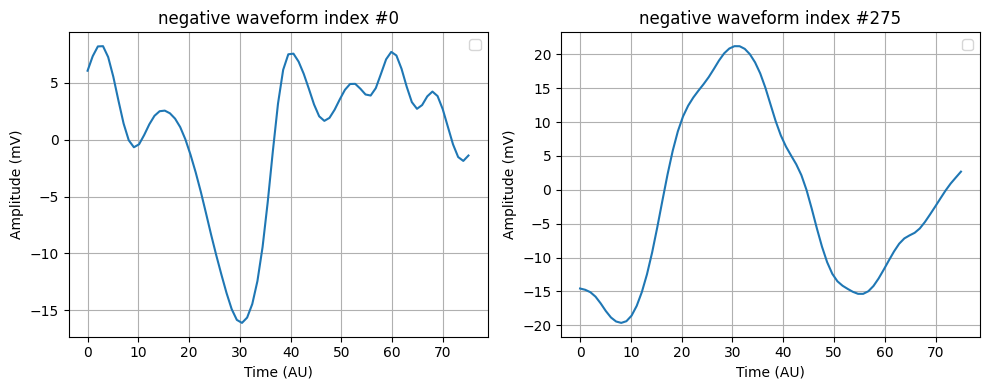

In [138]:
plot_wave(neg_waveforms, 0, 275, 0)

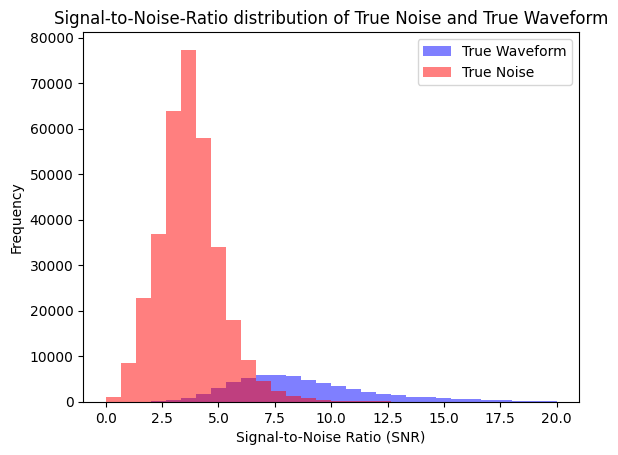

In [88]:
dataset1 = pos_waveforms[index_pos]
dataset2 = neg_waveforms[index_neg]

pos_SNR = get_snr(dataset1)
neg_SNR = get_snr(dataset2)


# Plot histogram for positive SNR dataset
plt.hist(pos_SNR, bins=30, range=(0, 20), color='blue', alpha=0.5, label='True Waveform')

# Plot histogram for negative SNR dataset
plt.hist(neg_SNR, bins=30, range=(0, 20), color='red', alpha=0.5, label='True Noise')

# Add labels and legend
plt.xlabel('Signal-to-Noise Ratio (SNR)')
plt.ylabel('Frequency')
plt.title('Signal-to-Noise-Ratio distribution of True Noise and True Waveform')
plt.legend()

# Show plot
plt.show()

In [92]:
print(np.mean(pos_SNR))
print(np.mean(neg_SNR))

8.918102451701978
3.7369722184563443


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


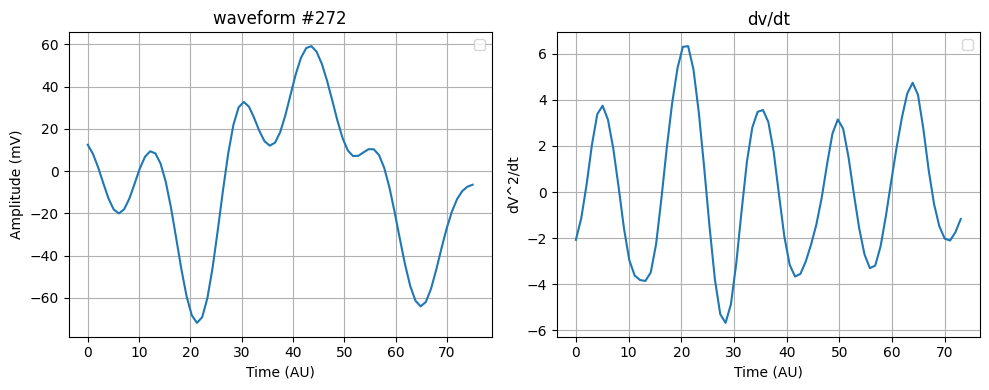

In [113]:
def get_derivative(waveform):
    derivative = np.zeros(len(waveform)-1)
    for i in range(0, len(derivative)):
        derivative[i] = waveform[i+1]-waveform[i]
    return derivative

waveform1 = neg_waveforms[100]
waveform2 = get_derivative(get_derivative(waveform1))
label1 = 'waveform #272'
label2 = 'dv/dt'

plt.figure(figsize=(10, 4))
t = np.linspace(0, 75, 75)
# Plot waveform 1
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(t, np.array(waveform1))
plt.title(label1)
plt.xlabel('Time (AU)')
plt.ylabel('Amplitude (mV)')
plt.grid(True)
plt.legend()

# Plot sample noise
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
t2 = np.linspace(0, 73, 73)
plt.plot(t2, np.array(waveform2))
plt.title(label2)
plt.xlabel('Time (AU)')
plt.ylabel('dV^2/dt')
plt.grid(True)
plt.legend()

# Display the plots
plt.tight_layout()  # Adjust the layout to make room for the labels/titles
plt.show()

# test wavelet transform

In [120]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [125]:
from sklearn.decomposition import PCA as pca
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from scipy.stats import zscore

In [126]:

def wavelet_transform(fin_data):
    wavelet_coeffs = []

    for signal in fin_data:
        coeffs = apply_wavelet_transform(signal)
        wavelet_coeffs.append(coeffs)

    return np.array(wavelet_coeffs)

def pca_transform(neg_waveforms, pos_waveforms, fin_labels):

    #####################################################
    ## preparing dataset, PCA for dimension reduction ###
    #####################################################

    def zscore_custom(x):
        return zscore(x, axis=-1)
    zscore_transform = FunctionTransformer(zscore_custom)

    # Aggregate all waveforms
    fin_data = np.concatenate([neg_waveforms, pos_waveforms])
    # Zscore to homogenize amplitudes
    zscore_fin_data = zscore_transform.transform(fin_data)
    # No need to fit PCA to ALL datapoints
    pca_obj = pca(n_components=10).fit(zscore_fin_data[::1000])
    print(f'Explained variance : {np.sum(pca_obj.explained_variance_ratio_)}')
    pca_data = pca_obj.transform(zscore_fin_data)

    # Scale PCA components
    scaler_obj = StandardScaler().fit(pca_data)
    X = scaler_obj.transform(pca_data)
    y = fin_labels

    return [X, y]


In [127]:
[X, y] = pca_transform(neg_waveforms, pos_waveforms, fin_labels)

Explained variance : 0.9536390464670774


In [131]:
len(X)

2641518

In [129]:
fin_data = np.concatenate([neg_waveforms, pos_waveforms])

In [136]:
def feature_extraction(waveform):
    '''feature consist of the rest 10 digits
    11. If the waveform downward deflection point is above -20 mV;
    12. If the waveform downward deflection point is in range between -20 ~ -30 mV;
    13. If the waveform downward deflection point is in range between -30 ~ -50 mV;
    14. If the waveform is positively deflected;
    15. If the deflection point is either the maximum or minimum point of the waveform
    16. If the waveform SNR is below 5.55;
    17. SNR value
    18

    '''
    feature = []
    feature.append(waveform[30])  # 11
    feature.append(waveform[30] < -30)  # 12
    feature.append(waveform[30] < -50)  # 13
    return np.array(feature)

In [137]:
X_new = np.empty(shape=(len(X), X.shape[1]+3))

for i in range(0, len(fin_data)):
    waveform = fin_data[i]
    X_new[i] = np.concatenate([X[i], feature_extraction(waveform)])
    
print(X_new[0])
    

[-8.05377727e-01 -3.58915637e-01  4.40864589e-03 -1.64376791e-01
 -8.65189829e-01 -7.84674424e-01  1.37073484e+00 -1.31312298e+00
  6.33564677e-01 -7.56509294e-01 -1.60989738e+01  0.00000000e+00
  0.00000000e+00]


In [140]:
print(fin_data[1][30])

-17.60060138911609
